# **Notebook AAPL**
Time Series Forecasting of AAPL stock data

**Granularity**: daily data

**Source**: Yahoo! Finance

**Time period**: 2010-01-04 / 2022-12-30

**Models**: ARIMA + Facebook Prophet


# Importing libraries

In [ ]:
!pip install pmdarima
!pip install prophet
import itertools
import os
import io
import warnings
import math
import datetime
import itertools
warnings.filterwarnings('ignore')
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from sklearn.metrics import r2_score
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse
from statsmodels.graphics.gofplots import qqplot as qq
from scipy.stats import kurtosis
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats
import pylab


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL (1).csv


# Load the Data

In [ ]:
#Load the dataset
data = pd.read_csv(io.BytesIO(uploaded['AAPL.csv']) , index_col = 'Date', parse_dates = True)

# Preliminary Analysis

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516528,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412874,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401018,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443573,447610800


In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.658981,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.831772,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.847855,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.412415,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.731918,77034200


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3272 non-null   float64
 1   High       3272 non-null   float64
 2   Low        3272 non-null   float64
 3   Close      3272 non-null   float64
 4   Adj Close  3272 non-null   float64
 5   Volume     3272 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 178.9 KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3.272000e+03
mean,51.297746,51.869747,50.731996,51.321186,49.394303,2.562707e+08
std,47.328490,47.938843,46.732224,47.357062,47.751072,2.225648e+08
min,6.870357,7.000000,6.794643,6.858929,5.837761,3.519590e+07
25%,18.966697,19.121697,18.780178,18.967590,16.600964,1.023541e+08
50%,29.756251,29.981250,29.561250,29.814999,27.344628,1.666698e+08
75%,56.983748,57.309998,56.469999,56.777499,54.869695,3.456643e+08
max,182.630005,182.940002,179.119995,182.009995,180.683868,1.880998e+09


In [ ]:
#Check if data is null
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

So far we observe that there are no missing values in our dataset. Data is "missing" only for the weekends since the markets are closed, but we don't have to fill in additional values.

In [ ]:
#Let's print some more information about our data
print(data.shape)
print(data.columns)

(3272, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


# Plots

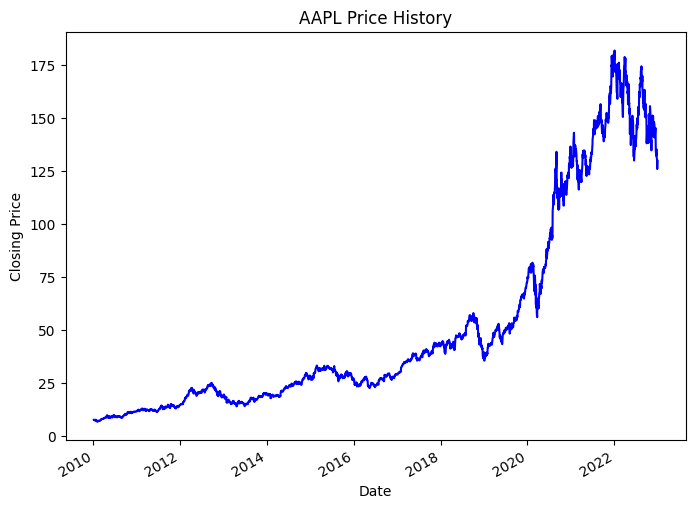

In [ ]:
#Static plot (more graphics for the Final Paper are implemented using Tableau)
plt.style.use('default') #set style
ax = data['Close'].plot(color = 'blue', figsize= (8,6))
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.set_title('AAPL Price History')
plt.show()

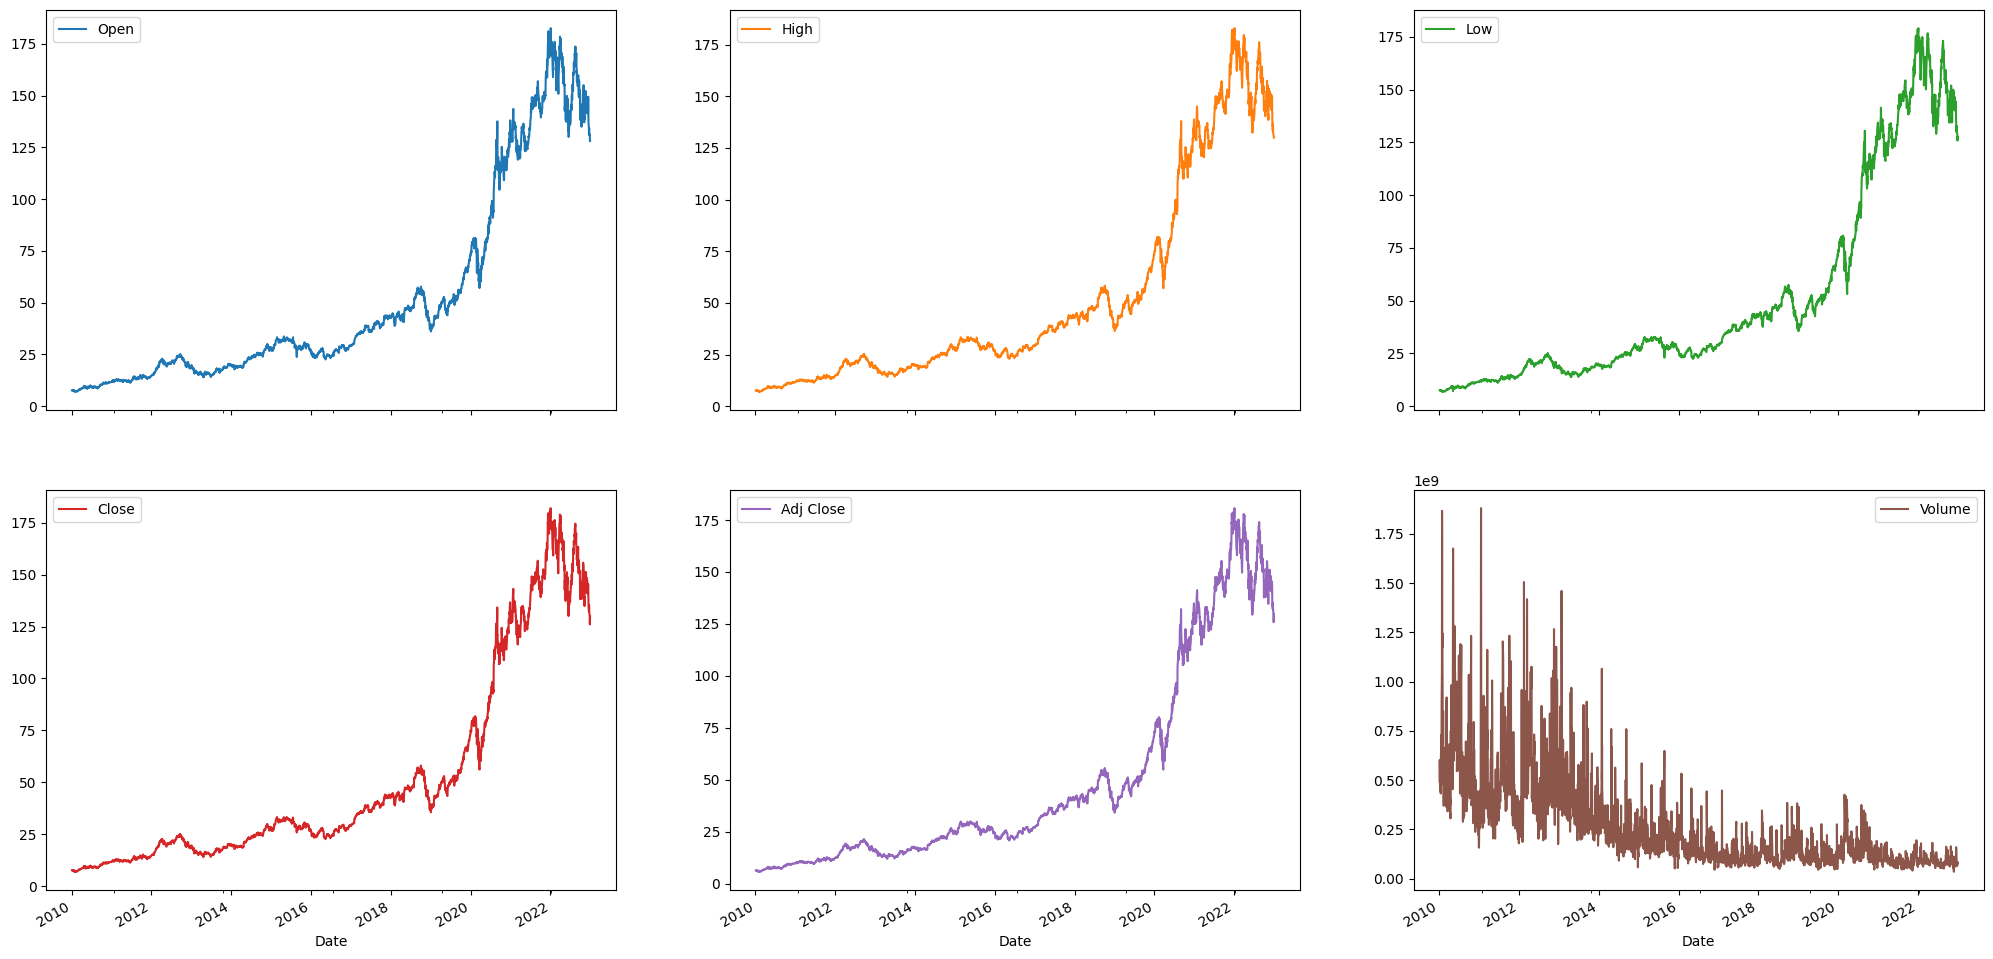

In [ ]:
#Plots of all the variables included in the dataset
data.plot(subplots= True, layout=(3,3) , figsize = (25,20), sharex = True, sharey = False)
plt.show()

We observe an increasing trends in all the plots apart from the last one depicting the volume of shares traded. In fact, we observe a reduction from 2012 towards the present days in the trading activity, still there is much of oscillation from one week to the other.

Text(0.5, 1.0, 'Distribution of Closing Price')

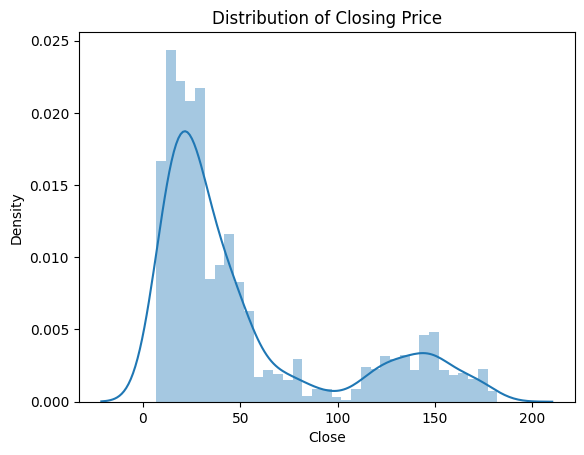

In [ ]:
#Distribution of the closing price for AAPL stock
sns.distplot(data['Close'])
plt.title('Distribution of Closing Price')

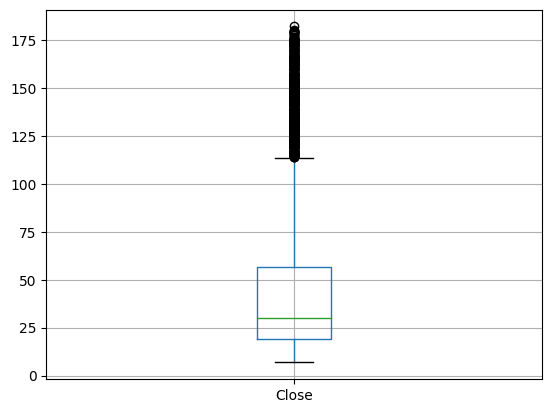

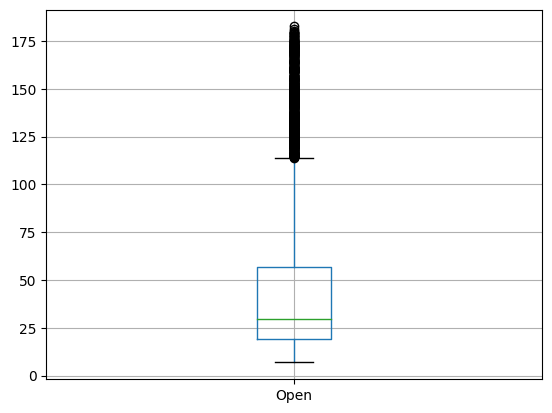

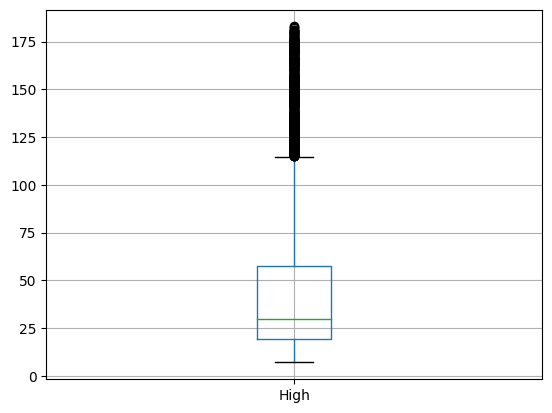

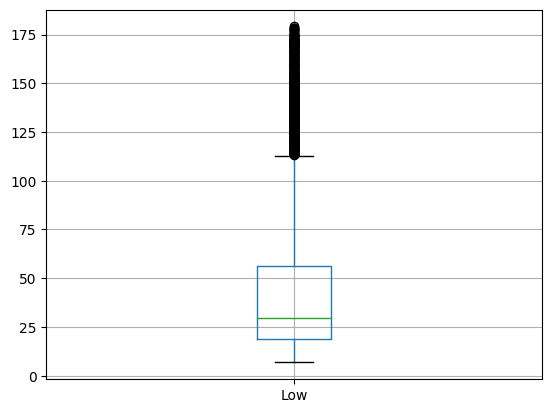

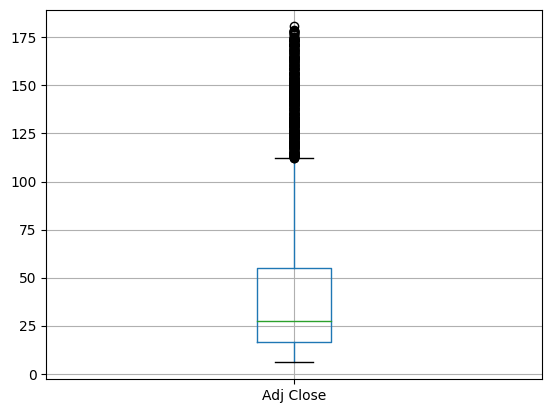

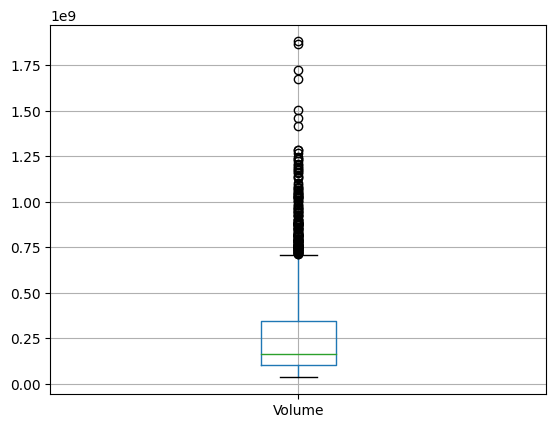

In [ ]:
#Outliers
cols = ['Close', 'Open','High', 'Low', 'Adj Close', 'Volume']
for i in cols:
    plt.subplots()
    axes = data.boxplot(column= [i])
plt.show()

Most of the data figure as outliers but we cannot conclude so since it is real time data.

# Feature Selection

At this point, we explore the correlation among the variable in the dataset.

In [ ]:
#Correlation matrix
corr = data.corr()

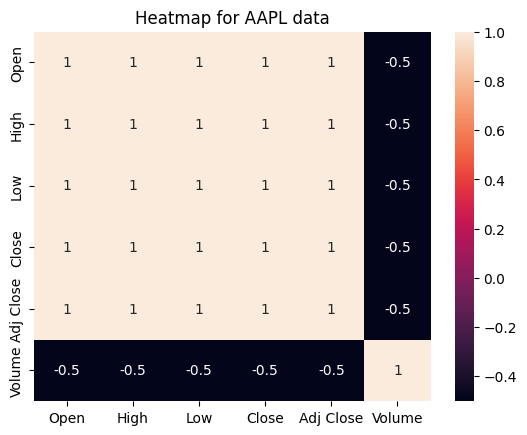

In [ ]:
sns.heatmap(corr, annot= True)
plt.title("Heatmap for AAPL data")
plt.show()

From the heatmap we can easily observe that 'Open', 'High', 'Low', 'Close' and 'Adj Close' are perfectly correlated one another, therefore to solve the problem of multicollinearity, we proceed by dropping these features, while keeping the Closing Price of the AAPL stock.
In addition to that, our previous remark regarding the downward trend for the volume is confirmed by a negative correlation coefficient meaning data the volume moves in the opposite direction from the Close, High, Low etc price of the stock.

In [ ]:
#Clean the dataset from unused variables
data = data.drop(axis=1,labels=['Open','High','Low','Adj Close','Volume'])

In [ ]:
data

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001


Text(0.5, 1.0, 'QQ Plot AAPL Price')

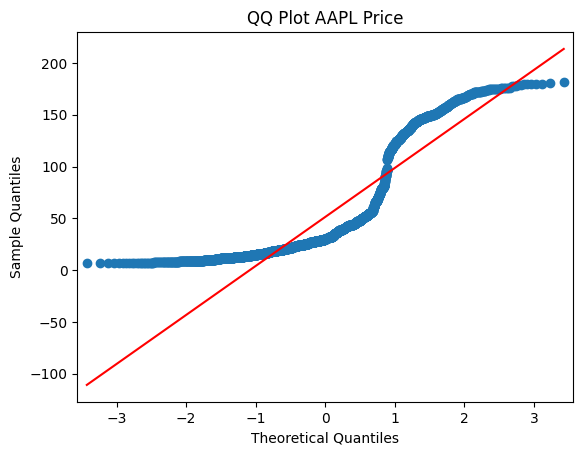

In [ ]:
qq_plot = qq(data['Close'], line='s')
plt.title('QQ Plot AAPL Price')

The Q-Q plot shows that the distribution is not normal, otherwise it would have followed the red line.

In [ ]:
print('Skewness of Distribution is ',data['Close'].skew())
print('Kurtosis of Distribution is ',data['Close'].kurtosis())

Skewness of Distribution is  1.3309557452692926
Kurtosis of Distribution is  0.37532103302568


Values of the kurtosis between +/- 1 are considered optimal. In this case 1.34 indicates that the data is not perfectly normal but still decent. A positive skewness is synonymous of a great number of smaller values.

## Decomposition of Time Series

<Figure size 1800x1600 with 0 Axes>

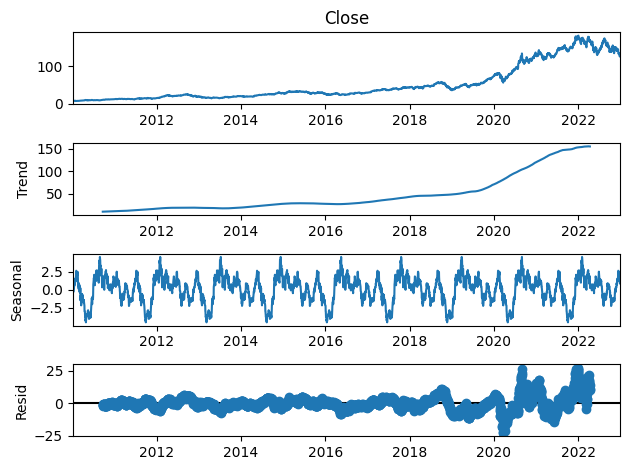

In [ ]:
plt.figure(figsize=(18,16))
from statsmodels.tsa.seasonal import seasonal_decompose as sd
decomposed_series = sd(data['Close'],model='additive', period = 360)
decomposed_series.plot()
plt.show()

The overall trend is upward.

# Stationarity of Time Series

Augmented Dickey-Fuller(**ADF**) Test

H0)Time series has a unit root - Non-stationary

H1)Time series does not have a unit root - Stationary

**Stationary** if we have constant mean,constant variance and No Trend and Seasonality.

In [ ]:
def ad_fuller_function(series):
  result_ad_fuller = adfuller(series)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Number of lags %f' %result_ad_fuller[2])
  
  print('Critical Values:')
  for k, v in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (k, v))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
  else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

In [ ]:
ad_fuller_function(data)

ADF Statistic: -0.287761
p-value: 0.927220
Number of lags 22.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Failed to Reject H0 - Time Series is Non-Stationary


As observed before during decomposition, the data is not stationary, now it has been also confirmed statistically.

Text(0.5, 0, 'Lags')

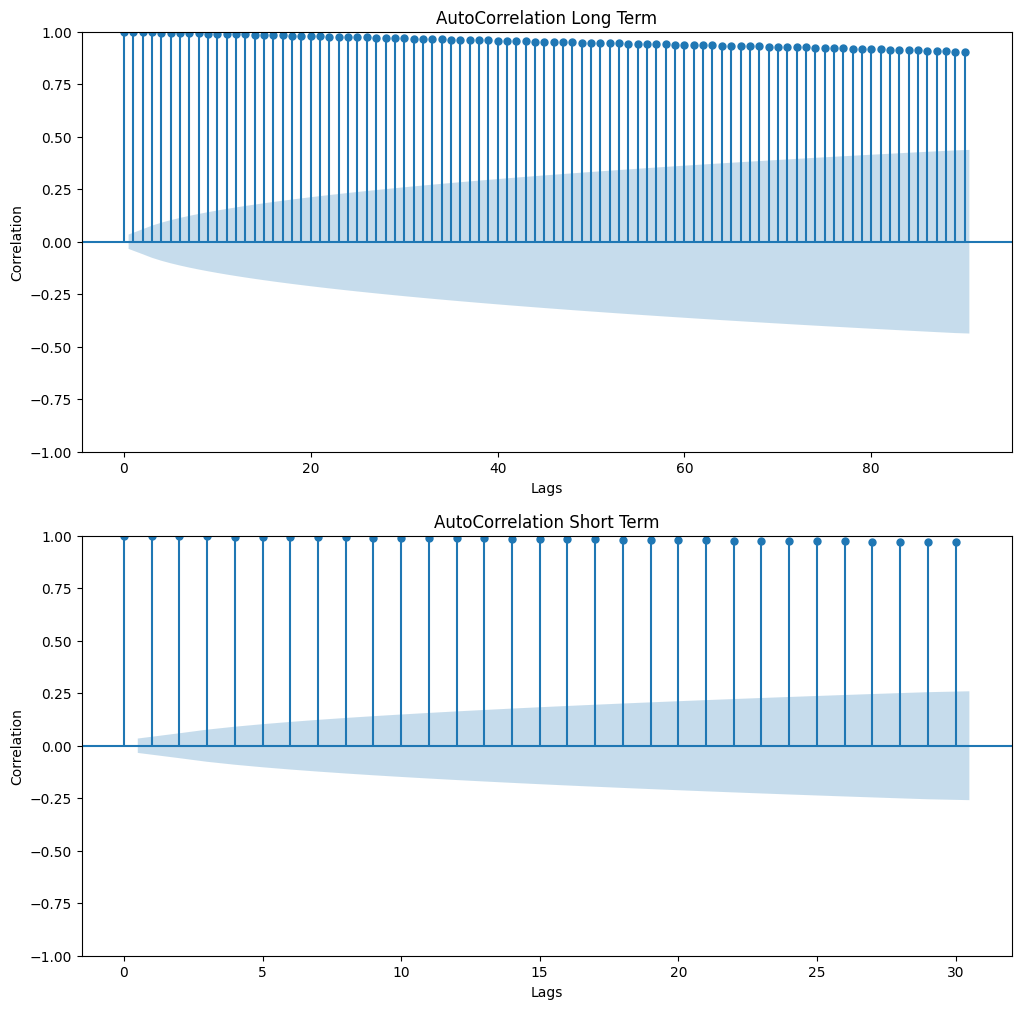

In [ ]:
#Plot the AutoCorrelation function (ACF) of the initial dataset for the Close variable
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,12))
acf = plot_acf(data['Close'],lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(data['Close'],lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

Autocorrelation values are almost 1 and outside of the light-blue shaded area.

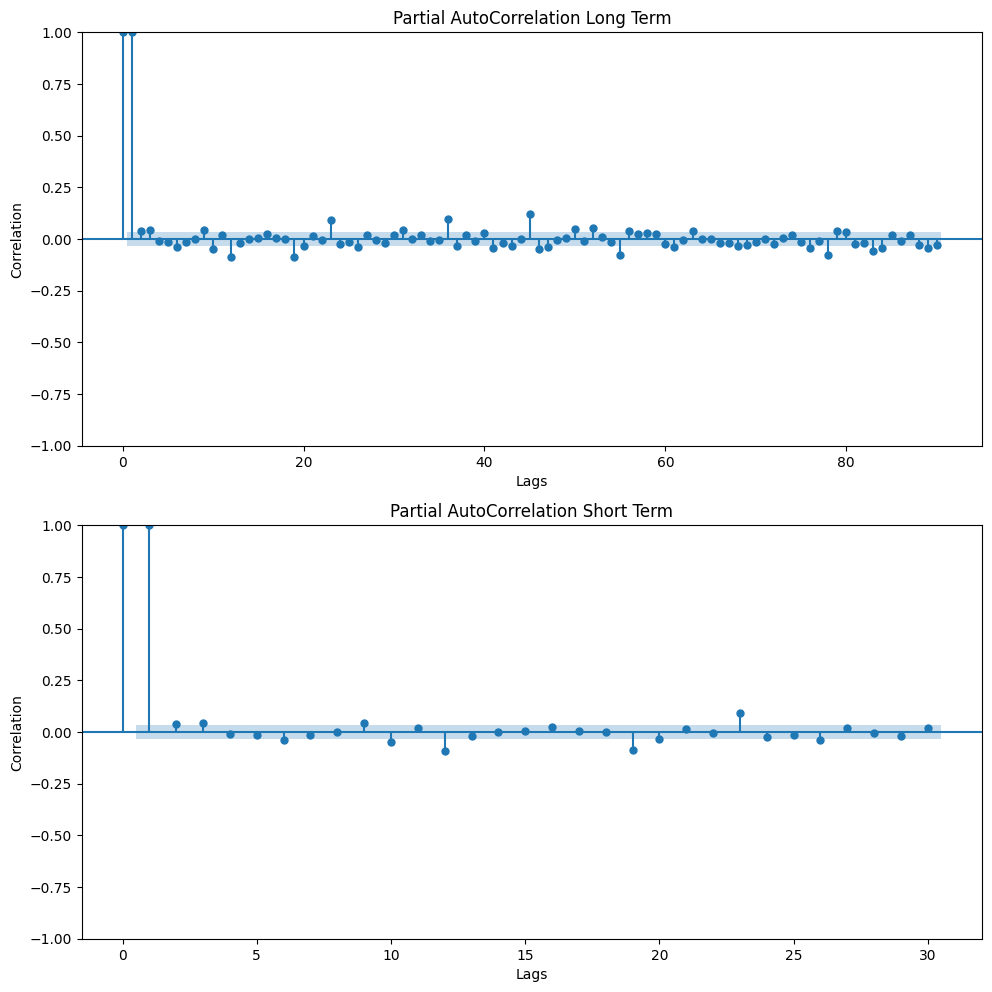

In [ ]:
#PCF for the initial dataset
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
pacf = plot_pacf(data['Close'],lags=90,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(data['Close'],lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

In [ ]:
#Differencing the data by one period
data_diff = data['Close'] - data['Close'].shift(1)
data_diff.dropna()

Date
2010-01-05    0.013215
2010-01-06   -0.121786
2010-01-07   -0.013929
2010-01-08    0.050000
2010-01-11   -0.066785
                ...   
2022-12-23   -0.369995
2022-12-27   -1.830002
2022-12-28   -3.989998
2022-12-29    3.570000
2022-12-30    0.319992
Name: Close, Length: 3271, dtype: float64

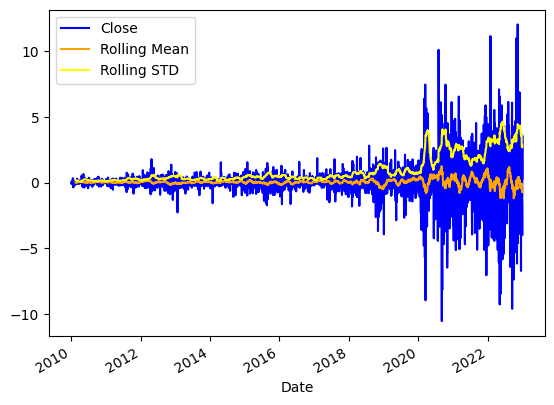

In [ ]:
data_diff[1:].plot(c='blue')
data_diff[1:].rolling(30).mean().plot(label='Rolling Mean',c='orange')
data_diff[1:].rolling(30).std().plot(label='Rolling STD',c='yellow')
plt.legend()

In [ ]:
ad_fuller_function(data_diff[1:])

ADF Statistic: -11.594232
p-value: 0.000000
Number of lags 21.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H0 - Time Series is Stationary


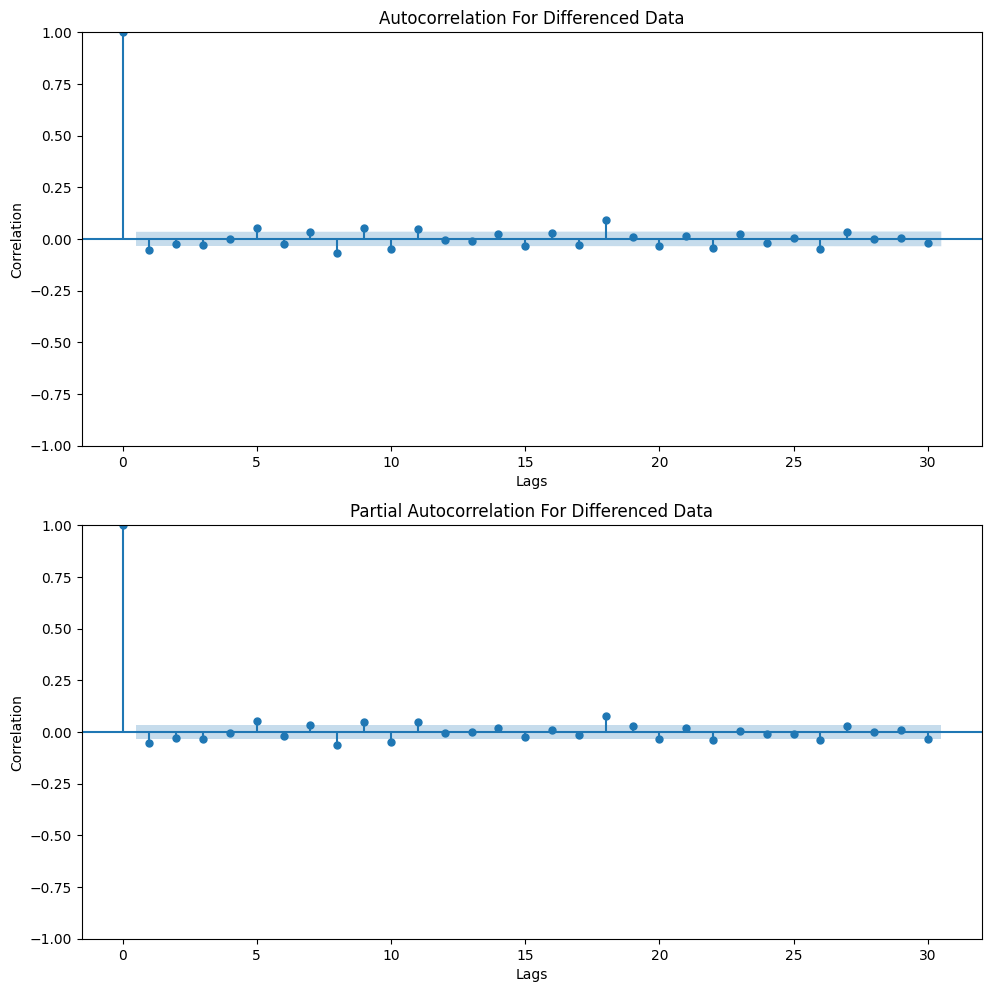

In [ ]:
#Plot the AutoCorrelation function (ACF) of the differenced data
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
acf = plot_acf(data_diff[1:],lags=30,ax=ax1)
pacf = plot_pacf(data_diff[1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced Data')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced Data')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

In [ ]:
#Number of differences required for a stationary series
#In this cell we also refers to other test for stationarity such as KPSS and PP tests, in addition to ADF

y = data['Close']
# augmented Dickey–Fuller test (adf test)
print("ADF Test: ",ndiffs(y, test='adf'))
# Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
print("KPSS Test: ",ndiffs(y, test='kpss'))
# Phillips–Perron (PP) test:
print("PP Test: ",ndiffs(y, test='pp'))

ADF Test:  1
KPSS Test:  1
PP Test:  1



*   Augmented Dickey Fuller Test (ADF): is Unit Root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.
*   Kwiatkowski–Phillips–Schmidt–Shin (KPSS): test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root.
* Phillips–Perron Test (PP): is a Unit Root Test, it is a modification of the Dickey Fuller test, and corrects for autocorrelation and heteroscedasticity in the errors

According to these test above, ACF and PACF plots we can conclude that the data is stationary.

# Seasonal ARIMA 

In [ ]:
#Time series data for the model
series = data['Close']
series
series.index = pd.DatetimeIndex(series.index).to_period('D')

#### Train Test split

In [ ]:
import statsmodels.api as sm
X = series
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = sm.tsa.SARIMAX(series,order=(1,1,1),seasonal_order=(2,2,0,12))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=124.261705, expected=42.602501
predicted=124.261705, expected=42.357498


# SARIMA Back-testing 

In machine learning we usually carry out a train/test split, so that the train data is used to feed the model and the test set is kept apart to check the performance metrics of the model. However, when dealing with time series data, this procedure is not longer applicable as it consider the oservations to be independent one another. In fact, in this case the data is ordered along a timeline, therefore data cannot be split at random. A common procedure that is used is called backtesting.

**Multiple Train/Test splits**

In [ ]:
#TimeSeriesSplit from sklearn library (variation of Kfold method)
ts_splits = TimeSeriesSplit(n_splits=6)
x = series.values
plt.figure(1)
fig = plt.figure(figsize=(24, 10))

i = 1
for train_index, test_index in ts_splits.split(x):
 train = x[train_index]
 test = x[test_index]
 print('Observations: %d' % (len(train) + len(test)))
 print('Training Observations: %d' % (len(train)))
 print('Testing Observations: %d' % (len(test)))
    
 plt.subplot(360 + i)
 plt.plot(train)
 plt.plot([None for i in train] + [x for x in test])
    #pyplot.title(''.format())
 i += 1
 plt.show()

In [ ]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=5)
X = series.values

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_list[index] = train
    test_list[index] = test
    index += 1

In [ ]:
import statsmodels.api as sm
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
    results=model.fit()

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(14,6))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')
    ax1.set_xlabel('Time')

    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')
    ax2.set_xlabel('Time')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

# Forecast SARIMA

In [ ]:
model = sm.tsa.SARIMAX(series,order=(1,1,1),seasonal_order=(2,2,0,12))
results=model.fit()
forecasts_train = results.predict(start='2010-01-04',end='2019-07-01')
forecasts_test = results.predict(start='2019-10-31',end='2021-12-31')

sd='2010-01-04'
ed='2019-07-01'
sd2='2019-10-31'
ed2='2021-12-31'

fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
series.loc[sd:ed].plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
series.loc[sd2:ed2].plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
##Function to Calculate Result Metrics
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

print(result_metrics(series[sd:ed],forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(series[sd2:ed2],forecasts_test,'SARIMA-Test Data'))

In [ ]:
#Create diagnostic plots
model = sm.tsa.statespace.SARIMAX(data['Close'], order=(1,1,1), seasonal_order = (2,2,0,12), trend='c')
results = model.fit()
results.plot_diagnostics(figsize = (10,10))
plt.show()
print(results.summary())


1.   Top-left: **Standardized residuals plot**, if the model is working correctly, there should be no obvious pattern in the residuals, they should be scattered.
2.   Top-right: **Histogram and Density plot**, it shows the distribution fo the residuals, if the model is good, the orange and green line should be almost the same.
3. Bottom-left: **Q-Q plot**, it compares the distributionof the residuals to a normal distribution, if the residuals are normally distributed, all the points should lie across the the red line.
4. Bottom-right: **Correlogram plot**, is the ACF plot of the residuals rather than the data, the model is doing well as long as the graph stays within the shaded area.



## Facebook Prophet


In [ ]:
#Preparing the data for the model
prophet_data = data
prophet_data['Date'] = prophet_data.index
prophet_data

In [ ]:
#Create a new dataframe object  with two columns
prophet_data.rename(columns={'Date':'ds',
                   'Close':'y'},inplace=True)
prophet_data

In [ ]:
#Train/Test split
prophet_train,prophet_test = split(prophet_data,train_size=0.8,shuffle=False)
print('Training Data Size :',len(prophet_train))
print('Testing Data Size :',len(prophet_test))

In [ ]:
#Model Fitting Basic Model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_train)

In [ ]:
future= prophet_model.make_future_dataframe(periods=len(prophet_test),freq='D')
future

In [ ]:
#make the prediction
forecast=prophet_model.predict(future)
forecast.index = prophet_data['y'].index


In [ ]:
prophet_df = pd.concat([forecast['yhat'],prophet_data['y']],axis=1,ignore_index=True)
prophet_df.columns = ['Predicted','Actual']
prophet_df

In [ ]:
#Plot Prophet train data
fig = plt.figure(figsize=(12,10))
prophet_df['Predicted'][:len(prophet_train)].plot(label='Predicted')
prophet_df['Actual'][:len(prophet_train)].plot(label='Actual')
plt.title('ProphetForecasting Train Data')
plt.ylabel('Stock Price')
plt.legend()

The training is uqite good for most of the data, in 2019/2020 tough the model is not able to fit the unexpected drop of the price.

In [ ]:
#Plot Prophet test data
fig = plt.figure(figsize=(12,10))
prophet_df['Predicted'][len(prophet_train):].plot(label='Predicted')
prophet_df['Actual'][len(prophet_train):].plot(label='Actual')
plt.title('Prophet Forecasting Test Data')
plt.ylabel('Stock Price')
plt.legend()

The performance of the set is really poor.

In [ ]:
print(result_metrics(prophet_df['Actual'][:len(prophet_train)],prophet_df['Predicted'][:len(prophet_train)],'Prophet Basic-Train Data'))
print(result_metrics(prophet_df['Actual'][len(prophet_train):],prophet_df['Predicted'][len(prophet_train):],'Prophet Basic-Test Data'))

In [ ]:
fig =prophet_model.plot_components(forecast)

# Prophet Hyper-parameter tuning



In [ ]:
#Use ParameterGrid
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.3,0.4],
              'holidays_prior_scale':[0.3,0.4],
              'n_changepoints' : [50,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

In [ ]:
df = prophet_data 
prophet_train_hyper,prophet_test_hyper = split(prophet_data,train_size=0.8,shuffle=False)
prophet_test_hyper.head(5)

In [ ]:
prophet_test_hyper.tail(5)

In [ ]:
len(prophet_test_hyper)
     

In [ ]:
print('Head',prophet_test.head(1))
print('Tail',prophet_test.tail(1))

In [ ]:
strt='2020-05-28'
end='2022-12-30'

model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for i in grid:
    test = pd.DataFrame()
    print(i)
    
    train_model =Prophet(changepoint_prior_scale = i['changepoint_prior_scale'],
                         holidays_prior_scale = i['holidays_prior_scale'],
                         n_changepoints = i['n_changepoints'],
                         seasonality_mode = i['seasonality_mode'],
                         weekly_seasonality=False,
                         daily_seasonality = False,
                         yearly_seasonality = True,
                         )
    
    train_model.fit(prophet_train_hyper)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test_hyper), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>=strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)---------------------------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(3)

In [ ]:
parameters['Parameters'][0]

The tuning is not much powerful as it strongly overfits. In the next section we try with a bit of manual tuning of the hyperparameters.

In [ ]:
prophet_tuned_model = Prophet(
                      growth='linear',
                      n_changepoints= 100,
                      changepoint_prior_scale= 0.001,
                      holidays_prior_scale = 0.02,
                      seasonality_prior_scale=0.03,
                      seasonality_mode = 'additive',
                      weekly_seasonality=False,
                      daily_seasonality = False,
                      yearly_seasonality = True,
                      changepoints=['2020-01-01']
                      )

prophet_tuned_model.fit(prophet_train_hyper)

In [ ]:
future_hyper= prophet_tuned_model.make_future_dataframe(periods=len(prophet_test_hyper),freq='D')
future_hyper=prophet_tuned_model.predict(future_hyper)

In [ ]:
future_hyper=prophet_tuned_model.predict(future_hyper)
future_hyper.index = prophet_data['y'].index    

In [ ]:
prophet_hyper_df = pd.concat([future_hyper['yhat'],prophet_data['y']],axis=1,ignore_index=True)
prophet_hyper_df.columns = ['Predicted','Actual']
prophet_hyper_df.tail()
     

In [ ]:
#Plot the training data 
fig = plt.figure(figsize=(12,10))
prophet_hyper_df['Predicted'][:len(prophet_train)].plot(label='Predicted')
prophet_hyper_df['Actual'][:len(prophet_train)].plot(label='Actual')
plt.title('Prophet Hyper Param Tuned- Forecasting -Train Data')
plt.ylabel('Stock Price')
plt.legend()

In [ ]:
#Plot the test data
fig = plt.figure(figsize=(12,10))
prophet_hyper_df['Predicted'][len(prophet_train):].plot(label='Predicted')
prophet_hyper_df['Actual'][len(prophet_train):].plot(label='Actual')
plt.title('Prophet Hyper Param Tuned- Forecasting -Test Data')
plt.ylabel('Stock Price')
plt.legend()

In [ ]:
result_metrics(prophet_hyper_df['Actual'][:len(prophet_train)],prophet_hyper_df['Predicted'][:len(prophet_train)],'Hyper-Tuned Prophet Train Data')

In [ ]:
result_metrics(prophet_hyper_df['Actual'][len(prophet_train):],prophet_hyper_df['Predicted'][len(prophet_train):],'Hyper-Tuned Prophet Test Data')

As observed in the two plots above, Prophet is doing pretty good in the training phase but it is not able to generalize. 

# **Results**
We can easily observe that the Prophet model, despitE its ease of fit and applicability is not performing well on the dataset, it strongly overfits the data especially with Parameter Grid search but also with manual tuning. SARIMA is performing much better instead, in particular the fact that is also statistically supported by tests, make this model more robust and effective. 